In [1]:
import scanpy as sc
import squidpy as sq
import numpy as np
import pandas as pd
from anndata import AnnData
import pathlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import skimage
import seaborn as sns
import tangram as tg
import warnings
warnings.simplefilter(action='ignore')

/home/wout/mambaforge/envs/tangram-env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Import the scRNA/snRNA data from the liver cell atlas
ad_sc = sc.read('/home/wout/Documents/Thesis_lokaal/Data_to_create_liver_atlas/adataAtlasRESOLVE.h5ad')
ad_sc=ad_sc[ad_sc.obs.typeSample=='nucSeq'] # Sparrow data was also set to 'nucleus', so makes sense to only use 'nucleus' single cell sources  

# Import the spatial data (Resolve MERFISH), this is the cell/gene matrix generated with the Sparrow pipeline   
name_anndata = "PS/ps_slice"
ad_sp=sc.read('/home/wout/Documents/Thesis_lokaal/Mouse_Liver_Resolve_Data/'+name_anndata+'.h5ad')
ad_sp.X=ad_sp.layers['raw_counts'] # Because the spatial data was normalized, to remove this 

In [3]:
ad_sp

AnnData object with n_obs × n_vars = 11794 × 96
    obs: 'region', 'instance', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_2_genes', 'pct_counts_in_top_5_genes', 'n_counts', 'shapeSize', 'leiden', 'portal_vein_EC45', 'LSEC45', 'LSEC Portal', 'LSEC Central', 'central_vein_EC45', 'stellateAll', 'stellate PeriPortal', 'stellate PeriCentral', 'FibroblastAll', 'fibroblastPortal', 'FibroblastsCentral', 'VSMC', 'capsular_fibroblasts45', 'Mesothelial cells', 'Hepatocytes', 'HepatocytesPortal', 'HepatocytesCentral', 'Cholangiocytes', 'cDC2s', 'Mig. cDCs', 'Neutrophils', 'Basophils', 'NK cells', 'ILC1s', 'T cells', 'pDCs', 'B cells', 'cDC1s', 'Kupffer cells', 'Capsule and Central Vein Mac', 'Portal LAM macrophages', 'Monocytes', 'LECs', 'Cleanliness', 'annotation', 'Hep', 'annotationSave', 'KC_intensity'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_c

In [4]:
ad_sc

View of AnnData object with n_obs × n_vars = 18666 × 31053
    obs: 'annot', 'typeSample', 'cluster_orig', 'annotation_CD45Neg', 'annotation_Fibro', 'annotation'
    uns: 'annot_colors'
    obsm: 'X_umap'

In [5]:
ad_sc.obs['annotation'].value_counts()
# get fractions
ad_sc.obs['annotation'].value_counts(normalize=True)

annotation
Hepatocytes          0.579985
stellate             0.137683
LSECs                0.092414
Kupffer cells        0.032037
fibroblast           0.030430
Mesothelial cells    0.027965
Cholangiocytes       0.026733
HsPCs                0.022126
portal_vein_EC45     0.020251
central_vein_EC45    0.011304
Other_ImmuneCells    0.008250
B cells              0.006215
VSMC                 0.003268
LECs                 0.001232
Endothelial cells    0.000107
Name: proportion, dtype: float64

In [6]:
# 11 cell types instead of 12 (portal LAM together with other immune cells, because no annotation with portal LAM in scRNA data)
# remove cells from scrRNA-seq that are not in annotations 
ad_sc=ad_sc[ad_sc.obs.annotation!='Endothelial cells']
ad_sc=ad_sc[ad_sc.obs.annotation!='HsPCs']
ad_sc=ad_sc[ad_sc.obs.annotation!='VSMC']
ad_sc=ad_sc[ad_sc.obs.annotation!='LECs']
ad_sc.obs['annotation'] = ad_sc.obs['annotation'].replace(['stellate'], 'Stel')
ad_sc.obs['annotation'] = ad_sc.obs['annotation'].replace(['central_vein_EC45'],'Central vein')
ad_sc.obs['annotation'] = ad_sc.obs['annotation'].replace(['portal_vein_EC45'],'Portal vein')
ad_sc.obs['annotation'] = ad_sc.obs['annotation'].replace(['fibroblast'], 'Fibr')
ad_sc.obs['annotation'] = ad_sc.obs['annotation'].replace(['Other_ImmuneCells'], 'Oth im')
ad_sc.obs['annotation'] = ad_sc.obs['annotation'].replace(['Cholangiocytes'], 'Chol')
ad_sc.obs['annotation'] = ad_sc.obs['annotation'].replace(['Hepatocytes'], 'Hepa')
ad_sc.obs['annotation'] = ad_sc.obs['annotation'].replace(['Kupffer cells'], 'Kupf')
ad_sc.obs['annotation'] = ad_sc.obs['annotation'].replace(['B cells'], 'B cell')
ad_sc.obs['annotation'] = ad_sc.obs['annotation'].replace(['LSECs'], 'LSEC')
ad_sc.obs['annotation'] = ad_sc.obs['annotation'].replace(['Mesothelial cells'], 'Meso')
np.unique(ad_sc.obs['annotation'])

array(['B cell', 'Central vein', 'Chol', 'Fibr', 'Hepa', 'Kupf', 'LSEC',
       'Meso', 'Oth im', 'Portal vein', 'Stel'], dtype=object)

In [9]:
round(ad_sc.obs['annotation'].value_counts(normalize=True)*100,2)

annotation
Hepa            59.59
Stel            14.15
LSEC             9.50
Kupf             3.29
Fibr             3.13
Meso             2.87
Chol             2.75
Portal vein      2.08
Central vein     1.16
Oth im           0.85
B cell           0.64
Name: proportion, dtype: float64

In [7]:
# import list of genes from genes.csv, no header
genes = pd.read_csv('genes.csv', header=None)
genes = genes[0].tolist()

In [8]:
#ad_sc = ad_sc[:,ad_sc.var_names.isin(genes)]
# get different elements from annotation
cellTypes = ad_sc.obs['annotation'].unique()
# make df with mean expression of each gene in each cell type
# df = pd.DataFrame(index = genes, columns=cellTypes)
df = pd.DataFrame(columns=cellTypes)
print(cellTypes)
ad_sc

['Stel', 'Meso', 'LSEC', 'Portal vein', 'Hepa', ..., 'Fibr', 'Central vein', 'Oth im', 'B cell', 'Kupf']
Length: 11
Categories (11, object): ['B cell', 'Chol', 'Hepa', 'Kupf', ..., 'Central vein', 'Fibr', 'Portal vein', 'Stel']


AnnData object with n_obs × n_vars = 18167 × 31053
    obs: 'annot', 'typeSample', 'cluster_orig', 'annotation_CD45Neg', 'annotation_Fibro', 'annotation'
    uns: 'annot_colors'
    obsm: 'X_umap'

In [9]:
for ct in cellTypes:
    ad_sc_ct = ad_sc[ad_sc.obs['annotation']==ct]
    df[ct] = ad_sc_ct.X.mean(axis=0).tolist()[0]
# change column names
df.columns = ['Stellate cell','Mesothelial cell','LSEC','PVEC','Hepatocyte','Cholangiocyte','Fibroblast','CVEC','Other immune cells','B cell','Kupffer cell']
df

,Stellate cell,Mesothelial cell,LSEC,PVEC,Hepatocyte,Cholangiocyte,Fibroblast,CVEC,Other immune cells,B cell,Kupffer cell
0,0.017510,1.806513,0.005217,0.015873,0.012470,0.252505,0.528169,0.009479,0.019481,0.008621,0.008361
1,0.000000,0.009579,0.000580,0.000000,0.000647,0.002004,0.001761,0.000000,0.000000,0.000000,0.000000
2,0.000778,0.000000,0.000580,0.000000,0.000554,0.000000,0.000000,0.000000,0.000000,0.000000,0.001672
3,0.001946,0.005747,0.006377,0.002646,0.012562,0.002004,0.000000,0.000000,0.019481,0.000000,0.003344
4,0.002335,0.001916,0.198261,0.391534,0.002309,0.010020,0.001761,0.094787,0.000000,0.000000,0.001672
...,...,...,...,...,...,...,...,...,...,...,...
31048,0.000389,0.000000,0.000000,0.000000,0.000369,0.000000,0.000000,0.000000,0.006494,0.008621,0.000000
31049,0.307393,0.402299,0.825507,0.785714,4.632551,1.026052,0.302817,0.587678,0.331169,0.603448,0.901338
31050,0.080545,0.126437,0.108406,0.084656,0.496120,0.128256,0.109155,0.104265,0.116883,0.086207,0.088629
31051,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [10]:
cellTypes_sort = ['Hepatocyte','LSEC','PVEC','CVEC','Cholangiocyte','Kupffer cell','Stellate cell','Fibroblast','Mesothelial cell','B cell','Other immune cells']
# sort columns
df = df[cellTypes_sort]
df

,Hepatocyte,LSEC,PVEC,CVEC,Cholangiocyte,Kupffer cell,Stellate cell,Fibroblast,Mesothelial cell,B cell,Other immune cells
0,0.012470,0.005217,0.015873,0.009479,0.252505,0.008361,0.017510,0.528169,1.806513,0.008621,0.019481
1,0.000647,0.000580,0.000000,0.000000,0.002004,0.000000,0.000000,0.001761,0.009579,0.000000,0.000000
2,0.000554,0.000580,0.000000,0.000000,0.000000,0.001672,0.000778,0.000000,0.000000,0.000000,0.000000
3,0.012562,0.006377,0.002646,0.000000,0.002004,0.003344,0.001946,0.000000,0.005747,0.000000,0.019481
4,0.002309,0.198261,0.391534,0.094787,0.010020,0.001672,0.002335,0.001761,0.001916,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
31048,0.000369,0.000000,0.000000,0.000000,0.000000,0.000000,0.000389,0.000000,0.000000,0.008621,0.006494
31049,4.632551,0.825507,0.785714,0.587678,1.026052,0.901338,0.307393,0.302817,0.402299,0.603448,0.331169
31050,0.496120,0.108406,0.084656,0.104265,0.128256,0.088629,0.080545,0.109155,0.126437,0.086207,0.116883
31051,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


<Axes: >

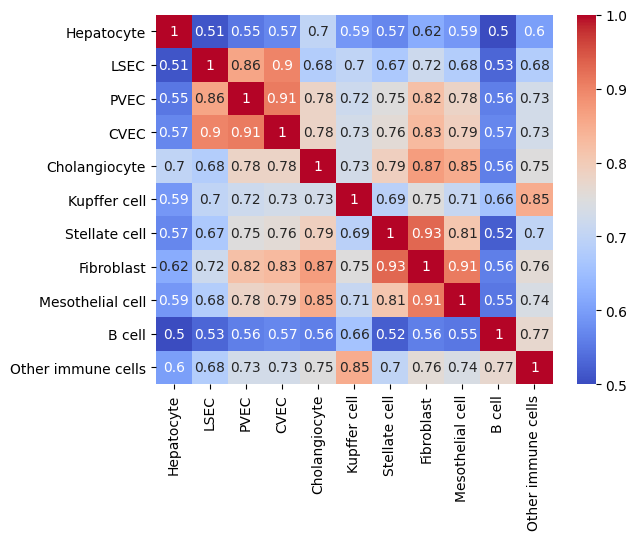

In [14]:
from matplotlib.colors import LogNorm
corr = df.corr()
corr = corr.round(2)
# visualize correlation matrix, green is positive correlation, red is negative correlation, boundaries are -1 and 1
sns.heatmap(corr, cmap='coolwarm', annot=True)

In [6]:
tg.pp_adatas(ad_sc,ad_sp) # if 'genes' is not specified then all overlapping genes are used for training 

INFO:root:95 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:95 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.


In [8]:
ad_map = tg.map_cells_to_space(ad_sc,ad_sp,
    mode="cells",
    density_prior='uniform', # spatial voxels are at single cell resolution --> must be set to 'uniform'
    num_epochs=500,
    device='cpu',) 

INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 95 genes and uniform density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.186, KL reg: 0.000
Score: 0.971, KL reg: 0.003
Score: 0.978, KL reg: 0.002
Score: 0.980, KL reg: 0.002
Score: 0.981, KL reg: 0.001


INFO:root:Saving results..


In [9]:
# probability that you find a cell in a voxel --> each row adds up to 1
ad_map.to_df()

cells,335,359,431,439,471,495,535,551,599,615,...,34442,34634,34698,34762,34954,35146,35210,35274,35338,35402
AATGGCTTCCTGTACC-27,7.715063e-06,3.699862e-05,3.340475e-05,9.133328e-06,1.028545e-05,3.158145e-05,2.480269e-04,1.293026e-05,9.203021e-06,2.087415e-06,...,1.050773e-05,3.769374e-06,3.371210e-06,3.604392e-06,9.497937e-06,6.581413e-06,2.161495e-05,1.760336e-05,3.107120e-06,4.163595e-06
AGTCAACAGAACAAGG-27,6.689769e-03,2.940520e-05,3.177205e-05,6.957880e-06,1.496826e-05,2.934751e-05,1.690922e-05,3.553014e-05,5.645394e-06,9.852984e-06,...,8.042561e-06,6.753192e-06,9.580243e-06,6.407950e-06,7.019778e-06,5.567647e-06,9.481253e-06,1.468678e-05,2.857701e-06,2.152598e-05
CTACTATAGGCTGGAT-27,3.450561e-06,1.684601e-04,8.610411e-06,9.242532e-06,2.291745e-05,6.699362e-05,4.918817e-06,6.066905e-06,4.598631e-06,5.223843e-06,...,8.161617e-06,4.345135e-06,4.930647e-06,1.082251e-05,3.482927e-06,3.972563e-06,1.565817e-05,1.275213e-05,5.156056e-06,5.162366e-07
CTCAACCTCAAGCTTG-27,3.495477e-06,3.901534e-05,5.479917e-06,7.266461e-07,7.335286e-07,7.207493e-07,1.720424e-05,2.649789e-06,3.822521e-06,6.774201e-06,...,6.880748e-06,2.313626e-06,2.033951e-06,2.033615e-05,1.783406e-06,1.658075e-06,6.547416e-06,1.523339e-05,2.026920e-06,8.374473e-06
GAGTTACAGCCTCATA-27,1.104401e-07,9.957861e-07,5.889938e-07,3.030359e-07,1.548332e-07,7.567619e-07,1.220214e-06,1.146284e-06,7.629658e-07,4.440729e-07,...,1.327616e-07,3.237827e-07,3.665470e-07,6.257727e-07,1.563303e-06,3.664075e-07,6.261962e-08,3.195671e-07,7.938133e-08,8.496211e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGGTTTAGAGACAAG-38,5.677831e-08,4.488826e-07,6.235642e-07,1.814734e-07,1.411688e-07,2.482684e-07,5.112977e-07,3.806519e-07,2.105090e-07,3.205826e-07,...,1.372633e-07,9.379068e-08,9.831772e-07,2.488919e-07,1.693132e-07,1.050822e-07,8.751412e-08,3.306473e-07,1.705331e-07,1.096179e-07
TTGTGTTTCGCTGTCT-38,1.184680e-07,2.110340e-07,4.877607e-07,1.018776e-07,6.006068e-07,3.036505e-07,4.404097e-07,1.798027e-07,6.906840e-07,1.459552e-06,...,2.856052e-07,5.392098e-07,3.974045e-07,4.268439e-07,2.600624e-07,3.081324e-07,2.052916e-07,9.723991e-07,5.971443e-08,1.159500e-07
TTGTTGTTCCACGTGG-38,2.452149e-06,1.319574e-06,1.326417e-06,2.661332e-07,1.572799e-06,8.417494e-07,8.866125e-07,4.939224e-07,9.954990e-07,9.263032e-07,...,8.876633e-07,7.570101e-07,6.101367e-07,7.947103e-07,4.643358e-07,6.698344e-07,1.531040e-06,1.271737e-06,2.078262e-06,1.189065e-06
TTTATGCGTACACGCC-38,6.979814e-07,1.124008e-06,1.077028e-06,1.188409e-06,1.003897e-06,7.336342e-07,1.782154e-06,5.350191e-07,6.468861e-07,7.332222e-07,...,8.441372e-07,4.789252e-07,8.031840e-07,4.005583e-07,8.029313e-07,1.983808e-07,4.010805e-07,5.989341e-07,3.075587e-07,8.726382e-07


In [10]:
ad_map.obs['annotation'] = ad_map.obs['annotation'].replace(['stellate'], 'Stel')
ad_map.obs['annotation'] = ad_map.obs['annotation'].replace(['central_vein_EC45'],'Central vein')
ad_map.obs['annotation'] = ad_map.obs['annotation'].replace(['portal_vein_EC45'],'Portal vein')
ad_map.obs['annotation'] = ad_map.obs['annotation'].replace(['fibroblast'], 'Fibr')
ad_map.obs['annotation'] = ad_map.obs['annotation'].replace(['Other_ImmuneCells'], 'Oth im')
ad_map.obs['annotation'] = ad_map.obs['annotation'].replace(['Cholangiocytes'], 'Chol')
ad_map.obs['annotation'] = ad_map.obs['annotation'].replace(['Hepatocytes'], 'Hepa')
ad_map.obs['annotation'] = ad_map.obs['annotation'].replace(['Kupffer cells'], 'Kupf')
ad_map.obs['annotation'] = ad_map.obs['annotation'].replace(['B cells'], 'B cell')
ad_map.obs['annotation'] = ad_map.obs['annotation'].replace(['LSECs'], 'LSEC')
ad_map.obs['annotation'] = ad_map.obs['annotation'].replace(['Mesothelial cells'], 'Meso')
tg.project_cell_annotations(ad_map, ad_sp, annotation="annotation")
annotations = list(pd.unique(ad_map.obs['annotation']))

INFO:root:spatial prediction dataframe is saved in `obsm` `tangram_ct_pred` of the spatial AnnData.


In [9]:
# tg.plot_cell_annotation_sc(ad_sp,annotations,perc=0.02)
# plot fails?

In [11]:
# ad_map.X.T @ one_hot_cell_annotation_matrix
# rows no longer add up to 1!
ad_sp.obsm['tangram_ct_pred']

,Stel,Meso,LSEC,Portal vein,Hepa,Chol,Fibr,Central vein,Oth im,B cell,Kupf
cells,,,,,,,,,,,
335,0.160486,0.969295,0.004496,0.001045,0.285862,0.112730,0.037735,0.000485,0.000950,0.000594,0.003886
359,0.036755,0.041128,0.002732,0.002143,1.410596,0.008585,0.014266,0.000898,0.001043,0.000822,0.001677
431,0.120663,0.091889,0.004051,0.002334,1.274371,0.006801,0.016217,0.000713,0.001739,0.000818,0.001615
439,0.008832,0.006989,0.001923,0.001118,1.486243,0.003204,0.011127,0.000598,0.001090,0.000597,0.001611
471,0.331924,0.037955,0.003329,0.002146,1.036140,0.087897,0.012529,0.000835,0.001124,0.000903,0.001702
...,...,...,...,...,...,...,...,...,...,...,...
35146,0.466664,0.003107,0.191432,0.164454,0.488951,0.003149,0.222176,0.008698,0.000993,0.000648,0.000873
35210,0.009881,0.062009,0.451630,0.914535,0.021631,0.004991,0.008851,0.028766,0.007013,0.019473,0.001624
35274,0.376396,0.035744,0.016440,0.002752,0.865439,0.037178,0.175155,0.000920,0.001250,0.001475,0.001542


In [12]:
ad_sp.obs['tangram'] = ad_sp.obsm['tangram_ct_pred'].idxmax(axis=1).to_list()


In [13]:
# get max value of each row
max_scores = ad_sp.obsm['tangram_ct_pred'].max(axis=1)
# get second highest value of each row
second_scores = ad_sp.obsm['tangram_ct_pred'].apply(lambda x: x.nlargest(2).values[-1], axis=1)
cleanliness = (max_scores - second_scores) / ((abs(max_scores) + abs(second_scores)) / 2)
ad_sp.obs['tangram_cleanliness'] = cleanliness

In [14]:
ad_sp.obs

,region,instance,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_2_genes,pct_counts_in_top_5_genes,n_counts,shapeSize,...,LECs,Cleanliness,annotation,Hep,annotationSave,KC_intensity,uniform_density,rna_count_based_density,tangram,tangram_cleanliness
cells,,,,,,,,,,,,,,,,,,,,,
335,1,1,7,2.079442,25,3.258097,60.000000,92.000000,25,3368.0,...,0.000000,0.179254,fibroblast,0,capsular_fibroblasts45,50.589074,0.000085,0.000016,Meso,1.089001
359,1,1,5,1.791759,247,5.513429,90.688259,100.000000,247,3596.0,...,-0.009021,1.734693,HepatocytesCentral,1,HepatocytesCentral,1.256674,0.000085,0.000162,Hepa,1.886678
431,1,1,8,2.197225,56,4.043051,71.428571,92.857143,56,2868.0,...,0.054046,0.018084,VSMC,0,VSMC,12.741283,0.000085,0.000037,Hepa,1.654021
439,1,1,11,2.484907,216,5.379897,69.907407,93.055556,216,3595.0,...,0.048177,0.462490,HepatocytesPortal,1,HepatocytesPortal,1.000000,0.000085,0.000142,Hepa,1.970275
471,1,1,5,1.791759,124,4.828314,91.935484,100.000000,124,3080.0,...,0.026132,1.612603,HepatocytesCentral,1,HepatocytesCentral,1.743506,0.000085,0.000081,Hepa,1.029508
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35146,1,1,16,2.833213,47,3.871201,38.297872,68.085106,47,2793.0,...,0.000000,0.002807,portal_vein_EC45,0,portal_vein_EC45,9.587898,0.000085,0.000031,Hepa,0.046645
35210,1,1,6,1.945910,43,3.784190,76.744186,97.674419,43,1357.0,...,0.000000,0.504407,portal_vein_EC45,0,portal_vein_EC45,26.805453,0.000085,0.000028,Portal vein,0.677669
35274,1,1,4,1.609438,13,2.639057,76.923077,100.000000,13,1348.0,...,0.000000,0.285714,fibroblast,0,FibroblastsCentral,44.546736,0.000085,0.000009,Hepa,0.787613


In [15]:
# rename column 'tangram' to 'annotation_tangram' ad_sp.obs.columns
ad_sp.obs.rename(columns={"tangram": 'annotation_tangram'},inplace=True)
ad_sp.uns['tangram'] = ad_sp.obsm['tangram_ct_pred']

In [16]:
ad_sp.write_h5ad('/home/wout/Documents/Thesis_lokaal/Mouse_Liver_Resolve_Data/PS/ps_slice_tangram.h5ad')

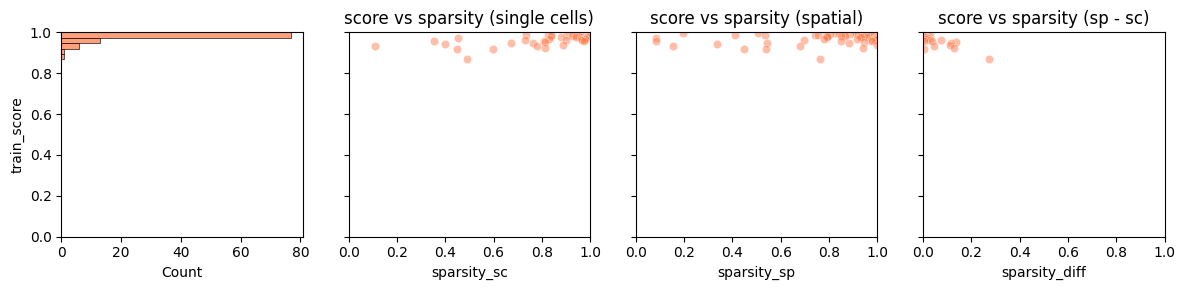

In [16]:
# How well do the counts of the mapped cell correspond with the measured counts in the spatial data (cosine similarity)
# Done for each training gene
tg.plot_training_scores(ad_map, bins=5, alpha=.5)

In [17]:
ad_map.uns['train_genes_df']

,train_score,sparsity_sc,sparsity_sp,sparsity_diff
spn,0.999875,0.999089,0.969897,-0.029193
cd3e,0.999731,0.998982,0.975508,-0.023474
chil3,0.999730,0.999786,0.990470,-0.009315
mmp12,0.999730,0.998446,0.792216,-0.206230
siglech,0.999583,0.999518,0.990381,-0.009137
...,...,...,...,...
ghr,0.931616,0.107200,0.153634,0.046434
nrxn1,0.921732,0.812600,0.942287,0.129687
slc40a1,0.920432,0.598468,0.539010,-0.059458
cyp2e1,0.918932,0.447177,0.449412,0.002235


In [18]:
# Predicted spatial expression of all genes based on mapped single cell data  
ad_ge = tg.project_genes(adata_map=ad_map, adata_sc=ad_sc)
ad_ge 

AnnData object with n_obs × n_vars = 11228 × 24212
    obs: 'region', 'instance', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_2_genes', 'pct_counts_in_top_5_genes', 'n_counts', 'shapeSize', 'uniform_density', 'rna_count_based_density'
    var: 'n_cells', 'sparsity', 'is_training'
    uns: 'annot_colors', 'training_genes', 'overlap_genes'

In [19]:
ad_ge.to_df().head()

,xkr4,gm1992,gm37381,rp1,sox17,mrpl15,lypla1,gm37988,tcea1,rgs20,...,ac132444.1,ac132444.5,csprs,ac132444.6,ac125149.3,ac168977.2,ac168977.1,ac149090.1,caaa01118383.1,caaa01147332.1
cells,,,,,,,,,,,,,,,,,,,,,
64,0.243317,0.000205,0.000013,0.000318,0.004587,0.657281,0.000359,0.154656,0.141839,0.085683,...,0.000015,0.000141,0.001812,3.511835e-06,0.000568,0.000030,0.000187,7.462193,0.763330,0.000069
66,0.507405,0.046902,0.000016,0.000379,0.017113,0.076391,0.000058,0.044191,0.035645,0.000480,...,0.000016,0.000090,0.000260,6.113416e-08,0.000413,0.000043,0.000031,2.933502,0.042840,0.004387
67,1.999756,0.000453,0.000014,0.000149,0.000860,0.008155,0.000035,0.022590,0.006357,0.001132,...,0.000006,0.000020,0.000523,2.244048e-07,0.000145,0.000012,0.000010,0.404297,0.020075,0.000038
68,0.214861,0.000209,0.000026,0.000321,0.004218,0.186937,0.000107,0.617922,0.012326,0.000806,...,0.000030,0.000179,0.000611,6.371517e-07,0.000665,0.000026,0.000045,2.559519,0.017266,0.000086
69,0.102434,0.000258,0.000034,0.000304,0.007575,0.025998,0.000075,0.011041,0.047639,0.135839,...,0.000007,0.000097,0.000550,2.514240e-07,0.000674,0.000030,0.000174,1.586848,0.561272,0.000089


In [20]:
genes = ['spn','chil3','mmp12','cxcl12'] # some training genes
# tg.plot_genes_sc(genes, adata_measured=ad_sp, adata_predicted=ad_ge, perc=0.02)
# plot fails?

In [21]:
# Leave-one-out cross-validation strategy (maybe not so interesting because we have so few genes)
# Should be run on the gpu
cv_dict, ad_ge_cv, test_gene_df = tg.cross_val(
                                     ad_sc,
                                     ad_sp,
                                     # cluster_label = 'annot', (for 'clusters' mode)
                                     mode='cells',
                                     device='cuda:0',
                                     cv_mode='loo', # also 10fold is possible
                                     return_gene_pred = True,
                                     density_prior = 'uniform',
                                     verbose = True, # print training details
                                    )

  0%|          | 0/98 [00:00<?, ?it/s]


RuntimeError: cuda runtime error (100) : no CUDA-capable device is detected at /tmp/pip-req-build-8yht7tdu/aten/src/THC/THCGeneral.cpp:50

In [22]:
### Same but with mode = clusters

In [23]:
ad_map_cl = tg.map_cells_to_space(ad_sc,ad_sp,
    mode="clusters",
    density_prior='uniform', # spatial voxels are at single cell resolution --> must be set to 'uniform'
    num_epochs=500,
    device='cpu',
    cluster_label='annotation')

Score: 0.151, KL reg: 0.184
Score: 0.553, KL reg: 0.009
Score: 0.554, KL reg: 0.009
Score: 0.554, KL reg: 0.009
Score: 0.555, KL reg: 0.009


In [24]:
ad_map_cl.to_df()

cells,64,66,67,68,69,71,72,73,74,77,...,28693,28743,28756,28866,28881,28929,28944,28992,29115,29130
0,1.279621e-04,3.150262e-05,2.237262e-07,0.000072,0.000083,1.125501e-04,1.250547e-04,1.269254e-04,1.522735e-04,1.478148e-04,...,1.414425e-04,0.000086,2.542813e-06,1.235291e-04,1.415911e-04,0.000098,1.398396e-04,1.120238e-04,5.040070e-07,0.000031
1,2.695018e-05,5.547802e-06,7.021463e-07,0.000011,0.000090,3.927615e-05,4.988465e-05,7.491511e-05,3.062766e-05,3.858249e-05,...,5.091207e-05,0.000077,2.194325e-05,4.047665e-05,2.812825e-05,0.000084,3.018536e-05,4.675505e-05,7.997298e-04,0.000007
2,3.264363e-06,1.708250e-06,2.755431e-06,0.000053,0.000072,1.721153e-05,6.645492e-06,3.041040e-06,3.440251e-07,3.547564e-07,...,4.514788e-08,0.000072,9.438446e-04,1.745196e-05,3.969612e-06,0.000048,1.363962e-07,2.426222e-05,1.343731e-07,0.000062
3,3.936068e-05,2.302329e-06,3.849526e-07,0.000013,0.000047,1.820017e-05,3.636657e-05,5.127103e-06,1.013611e-06,3.593776e-07,...,8.927903e-05,0.000047,1.549515e-06,1.437640e-05,8.471548e-07,0.000035,1.664467e-06,2.038318e-05,4.256797e-07,0.000003
4,1.247251e-06,5.775995e-04,1.649241e-07,0.000002,0.000008,4.831480e-06,1.731268e-07,3.308878e-07,1.100098e-07,3.485973e-07,...,1.761254e-06,0.000003,6.785402e-05,7.603283e-07,8.959728e-07,0.000004,1.086895e-07,1.346078e-04,7.393338e-07,0.001994
5,6.684597e-05,2.725261e-05,1.519812e-06,0.000038,0.000050,7.774338e-05,1.785475e-05,7.420561e-06,8.565697e-07,3.171821e-07,...,4.695190e-07,0.000050,3.503018e-06,2.389101e-05,4.342915e-05,0.000040,3.136749e-06,2.224670e-05,1.300474e-07,0.000160
6,2.241175e-05,3.883283e-04,6.732641e-04,0.000341,0.000006,1.206222e-05,8.954228e-06,3.998883e-06,1.486125e-05,4.102442e-07,...,7.531194e-05,0.000014,4.296284e-06,1.142472e-05,8.282228e-06,0.000004,3.500895e-06,9.065444e-06,1.269972e-06,0.000007
7,8.991234e-05,1.243774e-03,3.353831e-03,0.000715,0.000178,1.113501e-04,7.947311e-05,4.963464e-05,3.062743e-06,3.538782e-07,...,5.005377e-07,0.000177,1.680670e-06,1.051577e-04,2.941578e-05,0.000146,4.418842e-05,1.089770e-04,7.227192e-08,0.000006
8,6.405715e-06,3.892404e-06,1.897493e-07,0.000004,0.000112,1.697559e-04,1.650777e-06,1.818199e-06,1.826152e-07,2.678907e-07,...,4.506895e-07,0.000106,2.349275e-07,2.271079e-06,6.238049e-07,0.000034,3.604915e-06,7.722488e-06,1.846586e-07,0.000001
9,4.362018e-07,9.211690e-07,3.115111e-07,0.000009,0.000006,4.118870e-07,8.493031e-07,5.918144e-07,1.484893e-06,2.020842e-07,...,3.631024e-07,0.000005,1.833516e-07,1.598297e-06,1.451071e-06,0.000003,9.715382e-07,2.518749e-07,1.036660e-07,0.000003


In [25]:
ad_map_cl.obs['annotation']

0      Hepa
1      Stel
2      LSEC
3       Oth
4      Kupf
5      Endo
6      Fibr
7      Meso
8      Chol
9    B cell
Name: annotation, dtype: category
Categories (10, object): ['B cell', 'Chol', 'Endo', 'Hepa', ..., 'LSEC', 'Meso', 'Fibr', 'Stel']

In [26]:
ad_sp.obs['tangram_cl'] = ad_map_cl.to_df().idxmax(axis=0).to_list()
ad_sp.obs['tangram_cl'].replace(ad_map_cl.obs['annotation'].index.to_list(),ad_map_cl.obs['annotation'].to_list(), inplace=True)

In [27]:
# get max value of each row
max_scores = ad_map_cl.to_df().max(axis=0)
# get second highest value of each row
second_scores = ad_map_cl.to_df().apply(lambda x: x.nlargest(2).values[-1], axis=0)
cleanliness = (max_scores - second_scores) / ((abs(max_scores) + abs(second_scores)) / 2)
ad_sp.obs['tangram_cleanliness_cl'] = cleanliness

In [28]:
ad_sp.obs

,region,instance,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_2_genes,pct_counts_in_top_5_genes,n_counts,shapeSize,uniform_density,rna_count_based_density,tangram,tangram_cleanliness,tangram_cl,tangram_cleanliness_cl
cells,,,,,,,,,,,,,,,,
64,1,1,12,2.564949,150,5.017280,74.666667,92.000000,150,2545.0,0.000089,0.000105,Hepa,1.598467,Hepa,0.349282
66,1,1,16,2.833213,38,3.663562,36.842105,68.421053,38,1257.0,0.000089,0.000026,Kupf,0.507414,Meso,0.731508
67,1,1,15,2.772589,50,3.931826,52.000000,76.000000,50,3057.0,0.000089,0.000035,Meso,0.871606,Meso,1.331266
68,1,1,8,2.197225,84,4.442651,80.952381,95.238095,84,2071.0,0.000089,0.000059,Hepa,1.618017,Meso,0.709308
69,1,1,6,1.945910,52,3.970292,67.307692,98.076923,52,1637.0,0.000089,0.000036,Fibr,0.602986,Meso,0.454519
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28929,1,1,8,2.197225,108,4.691348,87.037037,97.222222,108,2285.0,0.000089,0.000075,Hepa,1.665446,Meso,0.390769
28944,1,1,11,2.484907,155,5.049856,71.612903,92.258065,155,1942.0,0.000089,0.000108,Hepa,1.886565,Hepa,1.039528
28992,1,1,10,2.397895,132,4.890349,71.969697,94.696970,132,3627.0,0.000089,0.000092,Hepa,0.794310,Kupf,0.183139


In [29]:
ad_sp.write_h5ad('/home/wout/Documents/Thesis_lokaal/Mouse_Liver_Resolve_Data/'+name_anndata+'_tangram.h5ad')